<h1 style="background-color:black;font-family:newtimeroman;color:skyblue;font-size:350%;text-align:center;border-radius: 15px 50px;">Predicting Fraud in Financial Payment Services</h1>


<center><img src="C:\Users\vijay\OneDrive\Documents\scam.jpg" style="border: 5px solid black; width:800px;height:400px;" /></center>
Fraudulent behavior can be seen across many different fields such as e-commerce, healthcare, payment and banking systems. Fraud is a billion-dollar business and it is increasing every year. The PwC global economic crime survey of 2018 [1] found that half (49 percent) of the 7,200 companies they surveyed had experienced fraud of some kind.even if fraud seems to be scary for businesses it can be detected using  machine learning.

**Paysim synthetic**:is dataset of mobile money transactions. Each step represents an hour of simulation. This dataset is scaled down 1/4 of the original dataset which is presented in the paper "PaySim: A financial mobile money simulator for fraud detection".The main technical challenge it poses to predicting fraud is the highly imbalanced distribution between positive and negative classes in 6 million rows of data. . The goal of this analysis is to solve both these issues by a detailed data exploration and cleaning followed by choosing a suitable machine-learning algorithm to deal with the skew. I show that an optimal solution based on feature-engineering and extreme gradient-boosted decision trees yields an enhanced predictive power of 0.997, as measured by the area under the precision-recall curve. Crucially, these results were obtained without artificial balancing of the data making this approach suitable to real-world applications.


<h3 style="background-color:black;font-family:newtimeroman;color:skyblue;font-size:200%;text-align:center;border-radius: 15px 50px;">Libraries And Utilities</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

<h3 style="background-color:black;font-family:newtimeroman;color:skyblue;font-size:200%;text-align:center;border-radius: 15px 50px;">Data Loading</h3>

In [2]:
df = pd.read_csv('FRAUD.csv.zip')

correct spelling of original column headers for consistency

In [5]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


Test if there any missing values in DataFrame. It turns out there are no obvious missing values but, as we will see below, this does not rule out proxies by a numerical value like 0.

In [4]:
df.isnull().values.any()

False

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


<h3 style="background-color:black;font-family:newtimeroman;color:skyblue;font-size:200%;text-align:center;border-radius: 15px 50px;">Exploratory Data Analysis</h3>

In this section , we wrangle with the data exclusively using Dataframe methods. This is the most efficient way to gain insights into the dataset. More elaborate visualizations follow in subsequent sections.

<i><b>Which types of transactions are fraudulent?</b></i>
We find that of the five types of transactions, fraud occurs only in two of them : 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs. These observations appear, at first, to bear out the description of fraudulent transactions in this dataset, namely, fraud is committed by first transferring out funds to another account which subsequently cashes it out. We will return to this issue later.

In [6]:
print('\n The types of fraudulent transactions are {}'.format(
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


<i><b>What determines whether the feature isFlaggedFraud gets set or not?</b></i>
It turns out that the origin of isFlaggedFraud is unclear, contrasting with the description provided. The 16 entries (out of 6 million) where the isFlaggedFraud feature is set do not seem to correlate with any explanatory variable. The data is described as isFlaggedFraud being set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. In fact, as shown below, isFlaggedFraud can remain not set despite this condition being met.

In [7]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


<i><b>Can oldBalanceDest and newBalanceDest determine isFlaggedFraud being set?</b></i> The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. This is presumably because the transaction is halted . Interestingly, oldBalanceDest = 0 in every such transaction. However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.

In [8]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) # 4158


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


<i><b>Can isFlaggedFraud be set based on seeing a customer transacting more than once?</i></b> Note that duplicate customer names don't exist within transactions where isFlaggedFraud is set, but duplicate customer names exist within transactions where isFlaggedFraud is not set. It turns out that originators of transactions that have isFlaggedFraud set have transacted only once. Very few destination accounts of transactions that have isFlaggedFraud set have transacted more than once.

In [9]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any())) # False

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any())) # False

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))) # 2


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


It can be easily seen that transactions with isFlaggedFraud set occur at all values of step, similar to the complementary set of transactions. Thus isFlaggedFraud does not correlate with step either and is therefore seemingly unrelated to any explanatory variable or feature in the data
Conclusion: Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in a seemingly meaningless way, we can treat this feature as insignificant and discard it in the dataset without loosing information.

<i><b>Are expected merchant accounts accordingly labelled?</b></i>

In [10]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? False


In [11]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False


Are there any merchants among destination accounts for CASH_OUT transactions? False


in fact, there are no merchants among any originator accounts. Merchants are only present in destination accounts for all PAYMENTS.

In [12]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) 


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


<i><b>Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?</b></i>

In [13]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that are not detected and are labeled as genuine? It turns out there are 3 such accounts.

In [14]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


However, 2 out of 3 of these accounts first make a genuine CASH_OUT and only later (as evidenced by the time step) receive a fraudulent TRANSFER. Thus, fraudulent transactions are not indicated by the nameOrig and nameDest features.
Conclusion: Noting  above that the nameOrig and nameDest features neither encode merchant accounts in the expected way, below, we drop these features from the data since they are meaningless.

<h3 style="background-color:black;font-family:newtimeroman;color:skyblue;font-size:200%;text-align:center;border-radius: 15px 50px;">Data Cleaning</h3>

From the exploratory data analysis (EDA) , we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X for analysis.

In [7]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)
X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2770409 entries, 2 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   oldBalanceOrig  float64
 4   newBalanceOrig  float64
 5   oldBalanceDest  float64
 6   newBalanceDest  float64
dtypes: float64(5), int32(1), int64(1)
memory usage: 158.5 MB


Imputation of Latent Missing Values

In [16]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).

Since the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.

In [8]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

<h3 style="background-color:black;font-family:newtimeroman;color:skyblue;font-size:200%;text-align:center;border-radius: 15px 50px;">Feature-engineering</h3>

Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we take  a step further and create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.

In [9]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

<h3 style="background-color:black;font-family:newtimeroman;color:skyblue;font-size:200%;text-align:center;border-radius: 15px 50px;">Data Visualization</h3>

In [19]:
limit = len(X)
def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    sns.set(rc={"axes.facecolor":"#121212"})
    sns.axes_style('ticks')
    ax = sns.stripplot(x=x, y=y,hue = hue, jitter = 0.4, marker = '.', size = 4, palette =['#00FFFF', '#3399FF'] )
    ax.set_xlabel('')
    ax.set_xticks([0,1],['genuine', 'fraudulent'], fontsize = 16)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.grid(True,color='black')
        handles, labels = ax.get_legend_handles_labels()
        legend=plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1),  loc=2, borderaxespad=0, fontsize = 16)
        for text in legend.get_texts():
            text.set_color("white")
    return ax

Dispersion over time

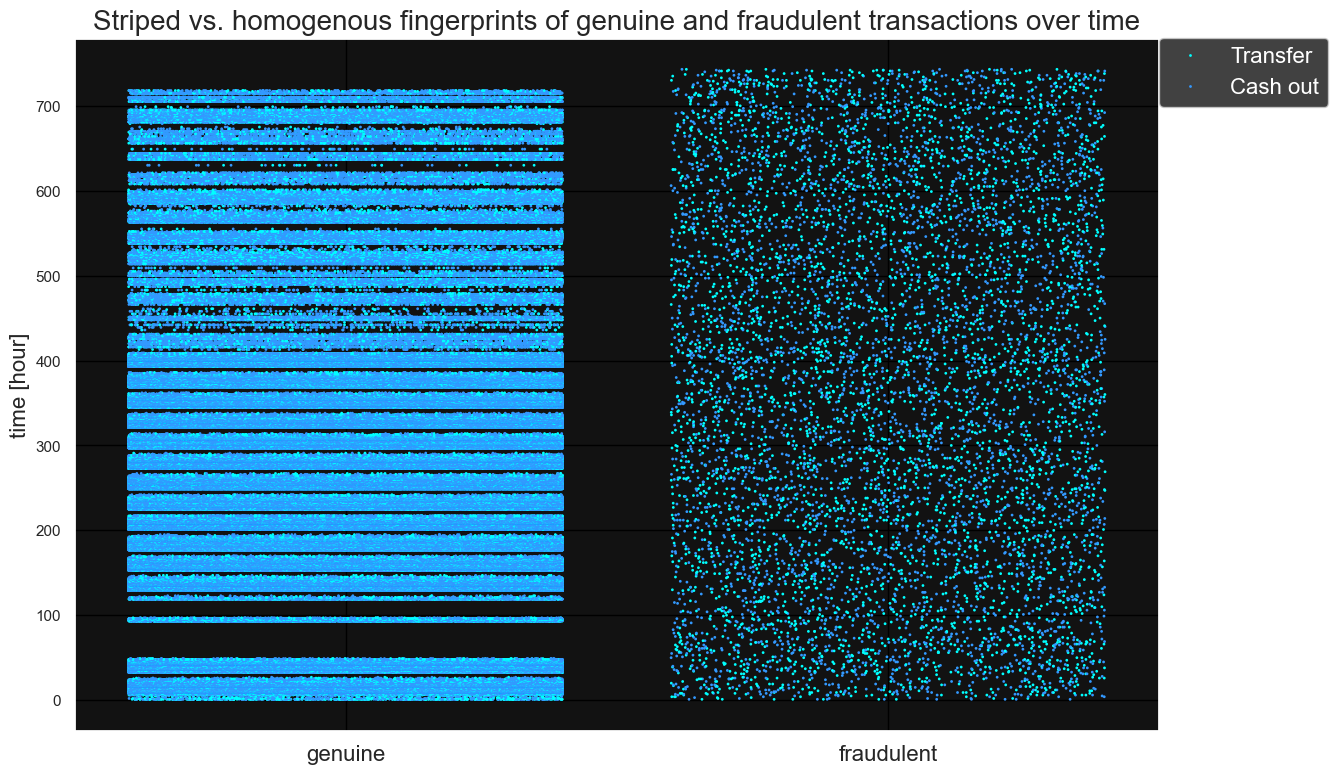

In [20]:

ax = plotStrip(Y[:limit], X['step'][:limit], X['type'][:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

The plot below shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions. Note that the the width of each 'fingerprint' is set by the 'jitter' parameter in the plotStrip function above which attempts to separate out and plot transactions occuring at the same time with different abscissae.

Dispersion over amount

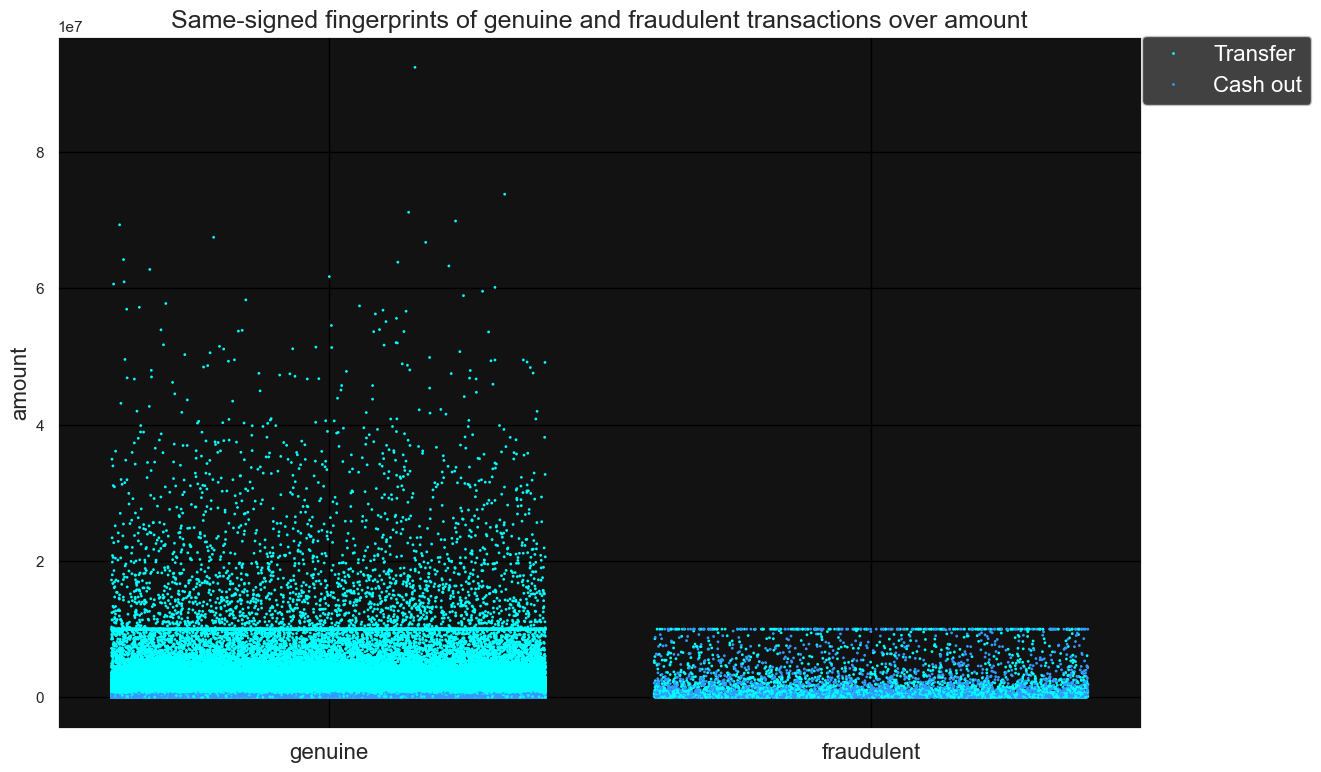

In [21]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

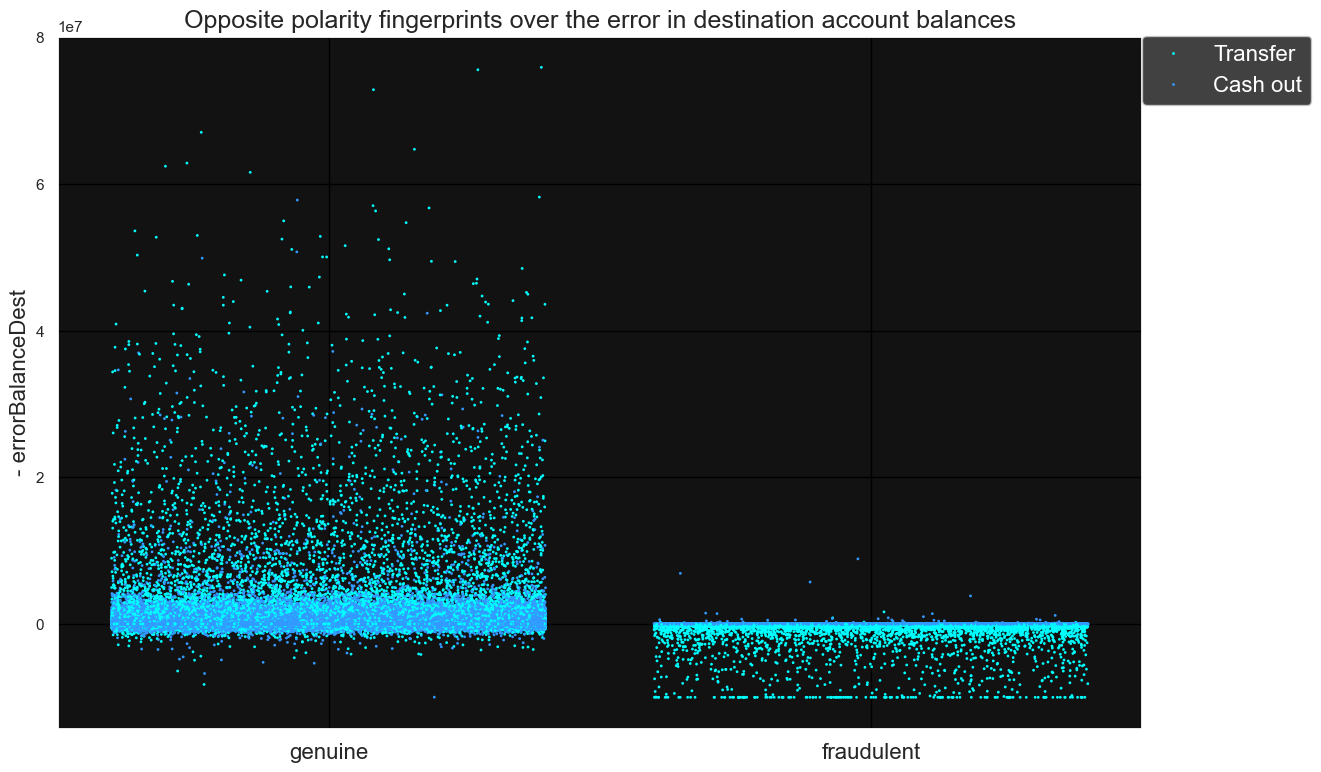

In [22]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

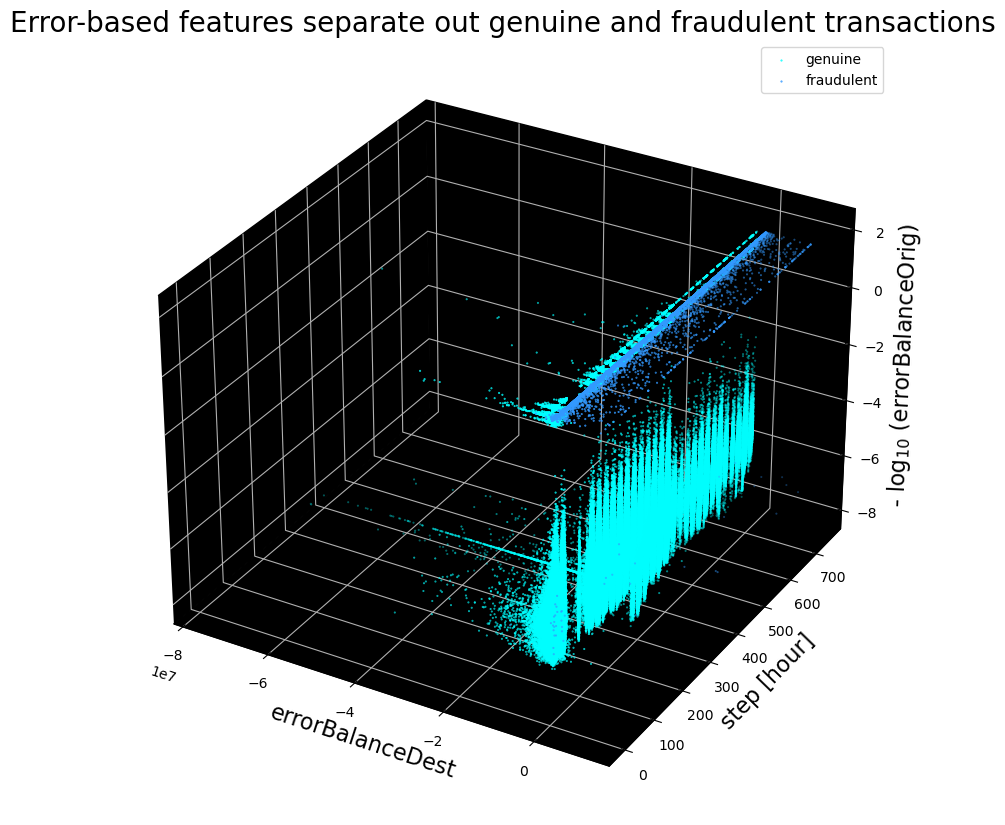

In [14]:
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)
sns.reset_orig
fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_pane_color((0,0,0,1))
ax.yaxis.set_pane_color((0,0,0,1))
ax.zaxis.set_pane_color((0,0,0,1))
ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = '#00FFFF', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = '#3399FF', marker = '.', \
  s = 1, label = 'fraudulent')
legend=plt.legend()
ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)
plt.axis('tight')
ax.grid(color='white')
plt.show()

Fingerprints of genuine and fraudulent transactions

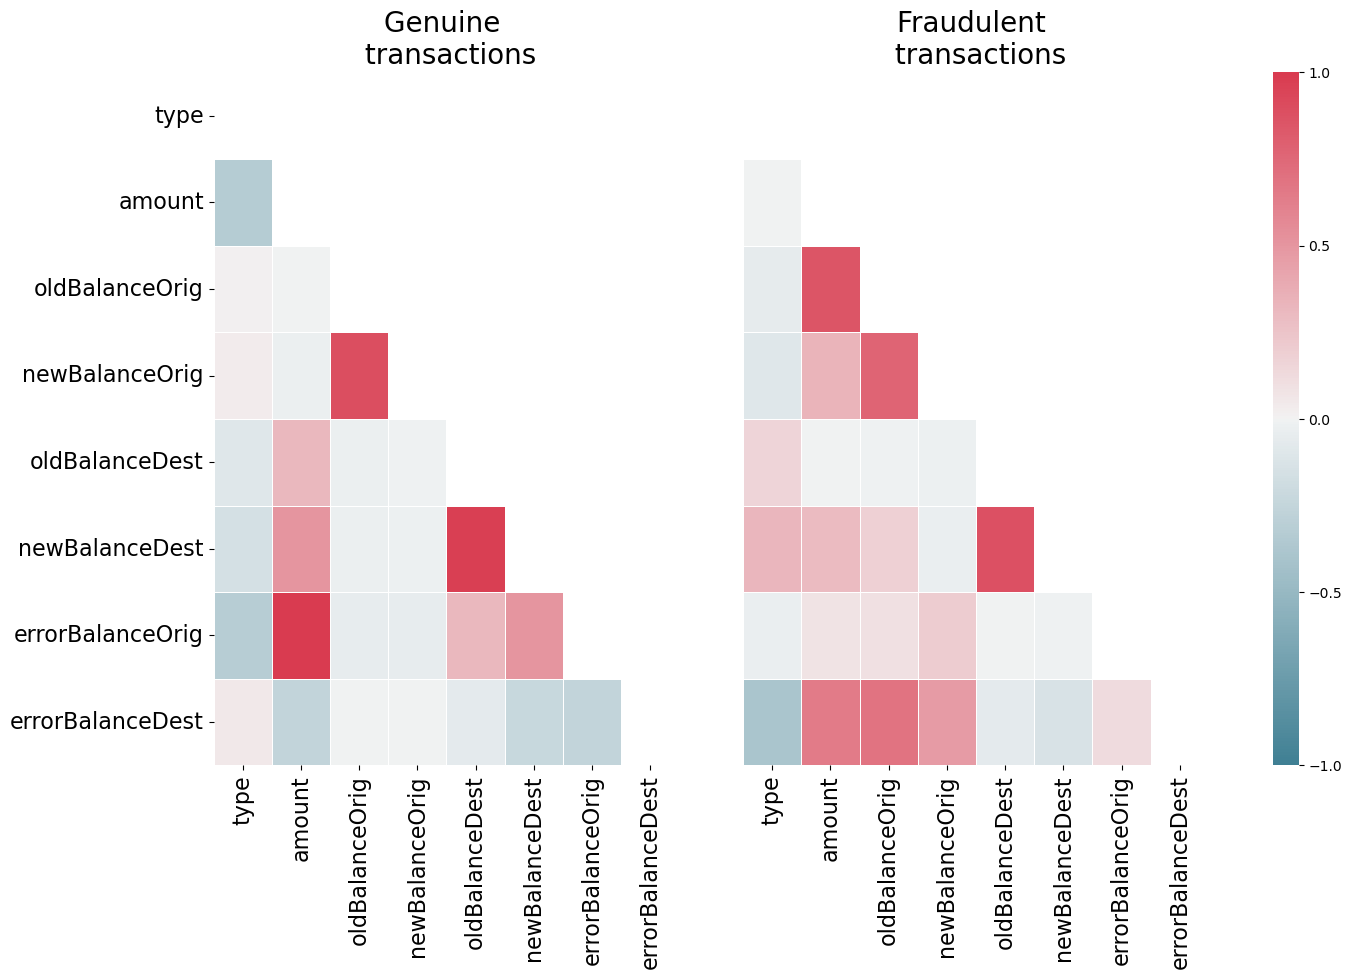

In [15]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]                 
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, 
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, 
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16)
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16)
ax1.set_title('Genuine \n transactions', size = 20)
correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, 
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, 
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', 
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16)
ax2.set_title('Fraudulent \n transactions', size = 20)
plt.show()


<h1 style="background-color:black;font-family:newtimeroman;color:skyblue;font-size:350%;text-align:center;border-radius: 15px 50px;"> Mechine learning model </h1>

In [10]:
X_train, X_test,y_train,y_test = train_test_split(X, Y, test_size = 0.2, random_state = 30)

In [22]:
def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    sns.set(rc={"axes.facecolor":"#121212"})
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## KNN

Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552415
           1       0.91      0.77      0.83      1667

    accuracy                           1.00    554082
   macro avg       0.95      0.88      0.92    554082
weighted avg       1.00      1.00      1.00    554082

Confusion Matrix of K-Nearest Neigbours: 
 [[552284    131]
 [   385   1282]]


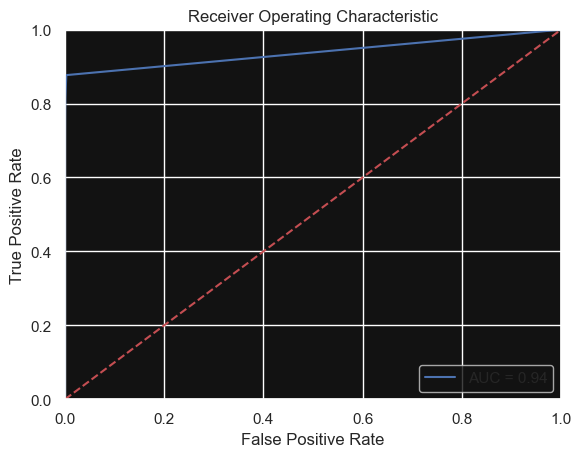

In [23]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

## Random Forest

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552415
           1       1.00      1.00      1.00      1667

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

Confusion Matrix of Random Forest Classifier: 
 [[552415      0]
 [     4   1663]]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


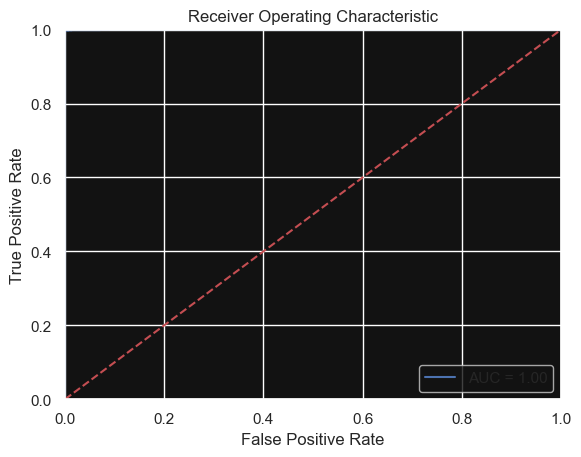

In [24]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight={0:1,1:10},n_jobs=4)

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

## XG boost

AUPRC = 0.9917292620696936
Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552415
           1       0.84      1.00      0.91      1667

    accuracy                           1.00    554082
   macro avg       0.92      1.00      0.96    554082
weighted avg       1.00      1.00      1.00    554082

Confusion Matrix of XGBoost: 
 [[552108    307]
 [     4   1663]]


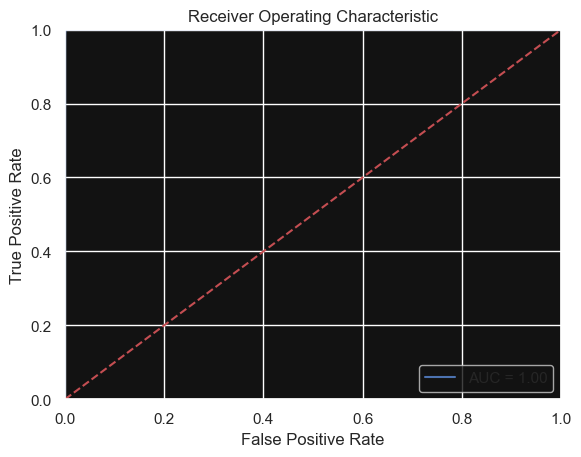

In [25]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights,n_jobs = 4)
probabilities = clf.fit(X_train, y_train).predict_proba(X_test)
print('AUPRC = {}'.format(average_precision_score(y_test,  probabilities[:, 1])))
y_pred = clf.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, clf.predict_proba(X_test)[:,1])

A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library or increase the weight of minority class using class weight. however, that the best result is obtained on the original dataset by setting class weight in  decision trees ,xg boost .that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. Among these algorithms, the random forest  slightly outperforms extreme gradient-boosted (XGBoost) algorithm . since we dont use artificial balancing in data points for classification it is best for applying in real world applications

<h1 style="background-color:black;font-family:newtimeroman;color:skyblue;font-size:350%;text-align:center;border-radius: 15px 50px;"> END </h1>

<center><img src="C:\Users\vijay\OneDrive\Documents\thank.jpg" style="border: 5px solid black; width:1000px;height:400px;" /></center>